# Hidden Markov Model with Zero-Inflated Poisson emissions for detecting change-points

## Introduction

In this Jupyter notebook using the R kernel, change-point detection is performed on data where the underlying model is a Hidden Markov Model (HMM) and emissions are drawn from Zero-Inflated Poisson distributions.

In [42]:
# Import the required libraries
library(dplyr)
library(ggplot2)
library(MCMCvis)
library(rjags)

# Ensure the figures are easy to view in the notebook
options(repr.plot.width=8, repr.plot.height=4)

## Data generation

In this section synthetic data is generated that may or may not contain a change-point. There are two states: normal; and abnormal.

In [47]:
sample_from_vector = function(p) {
    # Generate an index from a vector of probabilities.
    # 
    # Args:
    #   p: Vector of probabilities (must sum to unity).
    #
    # Returns:
    #   Random index weighted by the probability.
    
    # Generate a random sample from a vector of probabilities
    stopifnot(length(p) >= 1)
    stopifnot(near(sum(p), 1))

    # Use the vector as the probability of each index
    one_hot = rmultinom(1, 1, p)
    idx = which(one_hot == 1)
    
    # Return the index
    return(idx)
}

sample_from_zip_distribution = function(pi, lambda, N) {
    # Sample from a Zero-Inflated Poisson (ZIP) distribution.
    #
    # Args:
    #   pi: Probability of an extra zero.
    #   lambda: Mean of the Poisson disribution (ignoring extra zeros).
    #   N: Number of samples to generate.
    # 
    # Returns:
    #   N samples from the ZIP distribution.
    
    # Preconditions
    stopifnot(0 <= pi & pi <= 1)  # Must be a valid probability
    stopifnot(lambda > 0)         # Mean of the Poisson distribution must be > 0
    
    # Vector of the mixture from which the sample will be drawn
    mixture = rbinom(N, 1, 1-pi)
    
    # Generate samples from a Poisson distribution
    comp_poisson = rpois(N, lambda)
    
    # Generate samples from the zero distributiokn
    comp_zeros = rep(0, N)
    
    # Generate and return the mixture
    mixture * comp_zeros + mixture * comp_poisson
}

hmm_with_zip = function(p_initial, S, pi, lambda) {
    # Generate samples from an HMM with ZIP emissions.
    #
    # Args:
    #   p_initial: Probability of the initial state (normal and abnrormal)
    #   S: State transition matrix.
    #   pi: Probability of extra zeros in the normal and abnormal states.
    #   lambda: Mean of the Poisson distributions in the normal and abnormal states.
    #
    # Returns:
    #   List of emissions at each time step and the state.
    
    # Preconditions
    stopifnot(near(sum(p_initial), 1))  # Probability of the initial state must be (near) 1 
    stopifnot(all(dim(S) == c(2,2)))    # State transition matrix must be 2 x 2
    stopifnot(length(pi) == 2)          # Must be two values (normal and abnormal)
    stopifnot(all(0 <= p_initial & p_initial <= 1))  # Must be valid probabilities
    stopifnot(length(lambda) == 2)      # Must be two values (normal and abnormal)
    stopifnot(all(lambda > 0))          # Means of the Poisson distributions must be > 0
 
    # Vector of (ground-truth) states and samples
    states = rep(NaN, N)
    samples = rep(NaN, N)
    
    # Set the initial state and emission
    states[1] = sample_from_vector(p_initial)
    samples[1] = sample_from_zip_distribution(pi[states[1]], lambda[states[1]], 1)
    
    # Generate the remaining states and emissions
    for (i in 2:N) {
        
        # Hidden state
        prev_row = states[i-1]
        states[i] = sample_from_vector(S[prev_row,])
        
        # Emission
        samples[i] = sample_from_zip_distribution(pi[states[i]], lambda[states[i]], 1)
    }
    
    # Postconditions
    stopifnot(all(states == 1 | states == 2))  # States must be either 1 or 2
    stopifnot(all(samples >= 0))               # Emission values must be an integer
    
    # Return the ground-truth states and emissions
    list(state=states, sample=samples)
}

In [157]:
# Probability of the initial state (normal, abnormal) -- must sum to unity
p_initial = c(0.9, 0.1)

# State transition matrix
# row 1 refers to the 'normal' state
# row 2 refers to the 'abnormal' state
S = matrix(c(
    0.95, 0.05, 
    0.3, 0.7), nrow=2, byrow=TRUE)

# Probability of extra zeros for the normal and abnormal states
pi = c(0.8, 0.2)

# Mean of the Poisson distributions for the normal and abnormal states
lambda = c(5, 30)

# Number of samples to generate
N = 100

# Generate the samples from the HMM
x = hmm_with_zip(p_initial, S, pi, lambda)

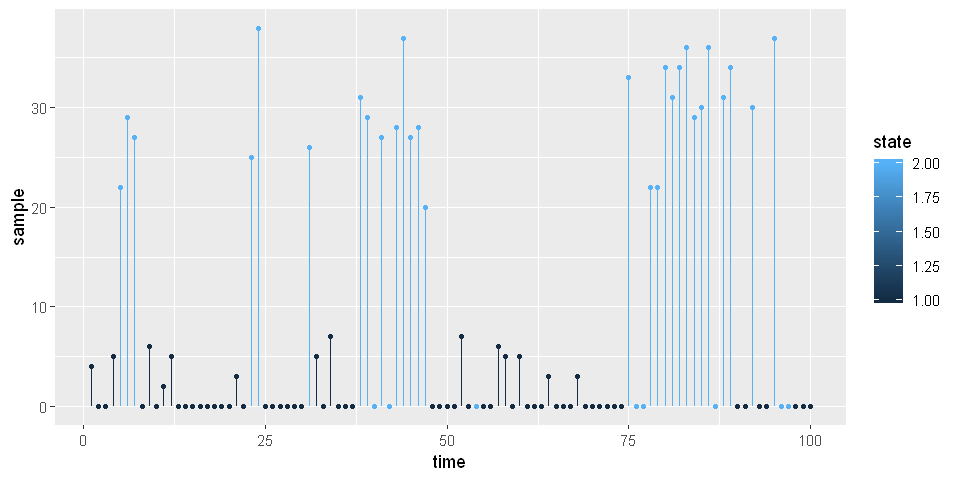

In [158]:
# Plot the samples and the states that generated them
df = data.frame(time=1:N, x)

ggplot(df, aes(x=time, color=state)) +
    geom_point(aes(time,sample),size=1) +
    geom_segment(aes(time, sample, xend=time, yend=sample-sample))

## Perform Bayesian inference

In this section, Bayesian inference is performed to infer the hidden state and the parameters of the ZIP distribution.

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 99
   Unobserved stochastic nodes: 204
   Total graph size: 1003

Initializing model



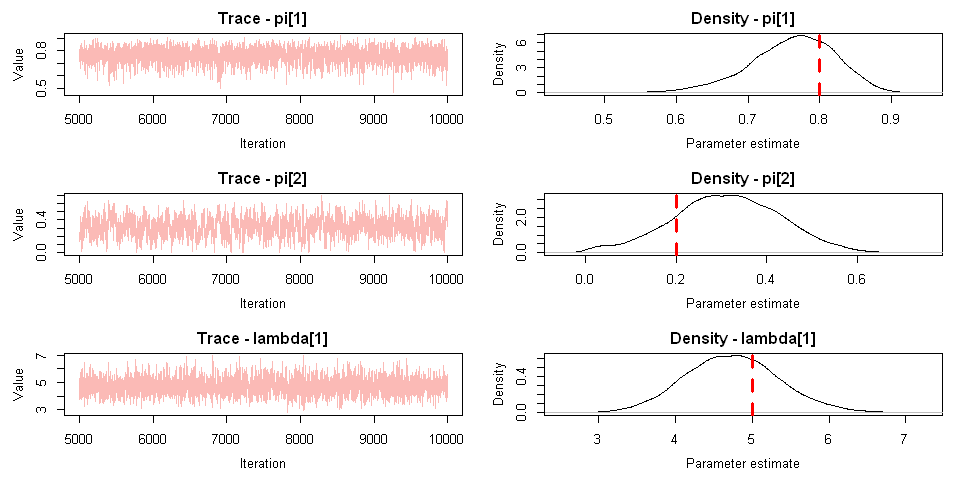

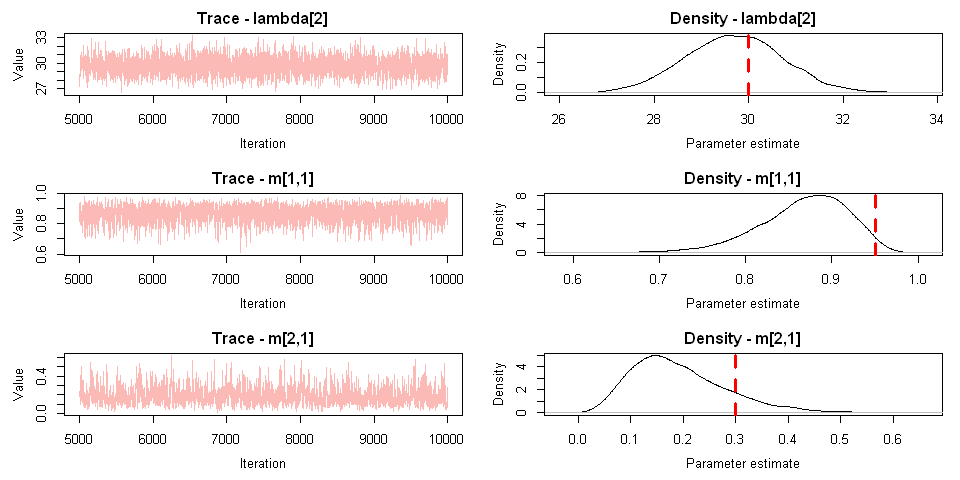

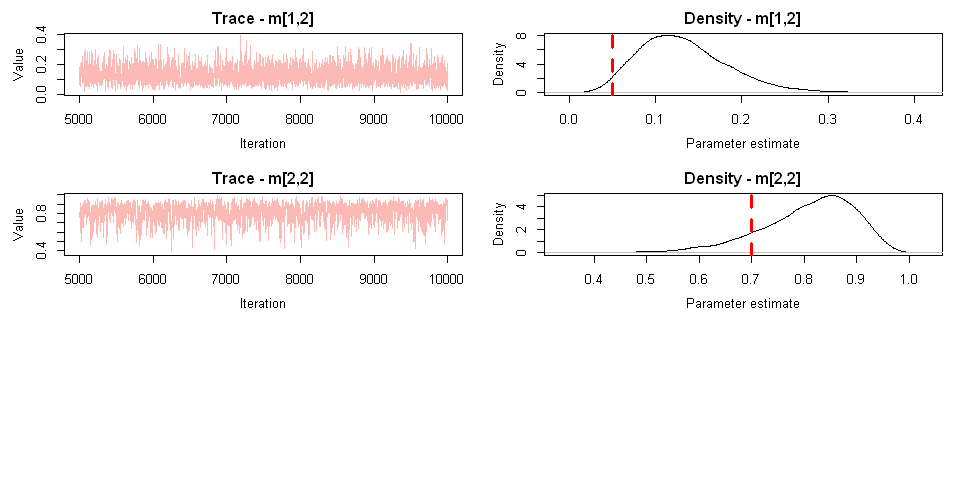

In [159]:
# Hidden Markov Model with Zero-Inflated Poisson distributed emissions for performing
# inference using JAGS

model_string = "
model {
    
    # Prior for the probability of extra zeros (normal and abnormal)
    pi[1] ~ dbeta(1,1)
    pi[2] ~ dbeta(1,1)

    # Prior for the mean of the Poisson distributions (normal and abnormal)
    lambda[1] ~ dexp(0.1)
    lambda[2] ~ dexp(0.1)

    # Prior for the state transition matrix
    m[1,1:2] ~ ddirch(alpha)  # from state 1 (normal)
    m[2,1:2] ~ ddirch(alpha)  # from state 2 (abnormal)

    # Note that the initial state is assumed to be known (normal)
    s[1] = 1

    # Likelihood of the N samples
    for (i in 2:N) {

        # Row to use in the state transition matrix
        row_index[i] = s[i-1]

        # Sample from the relevant row in the state transition matrix
        s[i] ~ dcat(m[row_index[i], 1:2])

        # Is the sample drawn from the zero-inflated part?
        zero[i] ~ dbern(pi[s[i]])  # 1=>zero-inflated, 0=>poisson

        # Lambda of the Poisson distribution (the 1e-10 is because a value of zero won't work)
        lambda_zip[i] <- ((1-zero[i]) * lambda[s[i]]) + (zero[i] * 1e-10)

        # Sample from the Poisson distribution where the mean has been 'modulated'
        y[i] ~ dpois(lambda_zip[i])
    }
}
"

model = jags.model(textConnection(model_string),
                   data = list(N=N, y=x$sample, alpha=c(1, 1)))

update(model, 
       50000, 
       progress.bar="none")

samp <- coda.samples(model, 
                     variable.names=c("pi", "lambda", "m", "s"), 
                     n.iter=10000, 
                     progress.bar="none")

# Order the ground-truth values
gv = c(pi, lambda, S)
MCMCtrace(samp, 
          gv=gv,
          params=c("pi", "lambda", "m"),
          pdf=FALSE)

In [166]:
p_state_2 = function(x) {
    # Calculate the probability that the HMM is in state 1.
    length(which(x == 2)) / length(x)
}

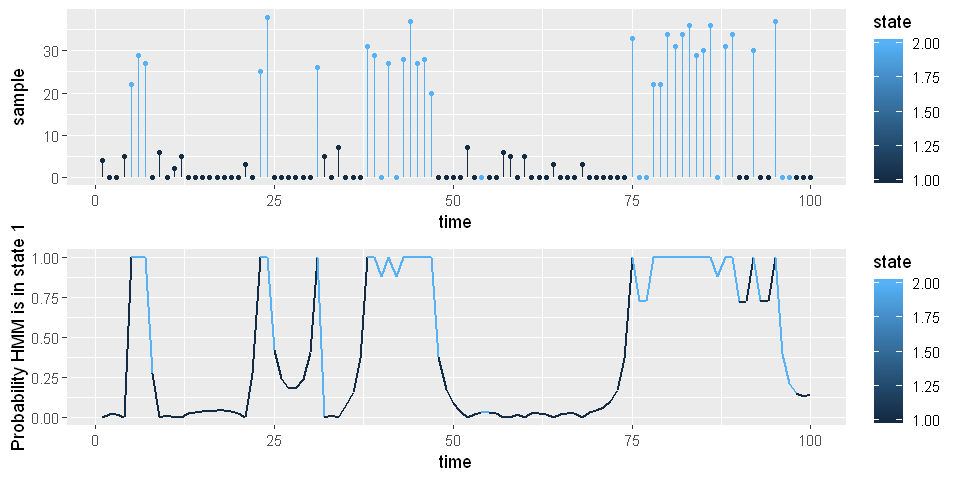

In [170]:
# Calculate the state probability at each time step
p_2 = rep(NA, N)
for (i in 1:N) {
    var = paste0("s[", i, "]")
    p_2[i] = p_state_2(as.matrix(samp)[,var])
}

# Build a data frame containing the original data and the state probability
df2 = data.frame(time=1:N, x, p_2)

library(gtable)
library(grid)

# Plot the original data and the probability that the HMM is in state 1
p1 = ggplot(df2, aes(x=time, color=state)) +
    geom_point(aes(time,sample),size=1) +
    geom_segment(aes(time, sample, xend=time, yend=sample-sample))

p2 = ggplot(df2, aes(x=time, color=state)) + 
    geom_line(aes(time, p_2), size=0.7) + 
    ylim(0, 1) + ylab("Probability HMM is in state 1")

g1 = ggplotGrob(p1)
g2 = ggplotGrob(p2)
g = rbind(g1, g2, size="first") # stack the two plots
g$widths <- unit.pmax(g1$widths, g2$widths)  # use the largest widths
grid.draw(g)